In [ ]:
# import libraries
import pandas as pd
import numpy as np

# libraries for data preprocessing
import nltk
# download modules available with NLTK
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# libraries for data split and feature extraction
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# library for evaluation
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay

# libraries for ML algorithms
from sklearn import svm
from sklearn import tree
from sklearn.naive_bayes import GaussianNB

# libraries for data plotting
import seaborn as sns
import matplotlib.pyplot as plt

RANDOM_SEED = 100

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load the data set

df = pd.read_csv('/content/drive/MyDrive/reviews_with_sentiment.csv')

print(df.shape)


(939668, 4)


In [ ]:
df = df.head(10000)
df.head()

top_id            date_modified  \
0  115447  2024-05-20 15:04:36.770   
1  115447  2024-05-20 15:04:36.770   
2  115447  2024-05-20 15:04:36.770   
3  115447  2024-05-20 15:04:36.770   
4  115447  2024-05-20 15:04:36.770   

                                                text  sentiment  
0  popped in here randomly on a sunday to get a b...          1  
1  everything wa delicious  even my husband  who ...          1  
2  the food is fresh  modern  and flavoursome  th...          1  
3  it ’ s a nice place to have a week end brunch ...          1  
4  nice scottish breakfast but service a little s...          1

In [ ]:
print(df.shape)

(10000, 4)


<Axes: xlabel='sentiment', ylabel='count'>

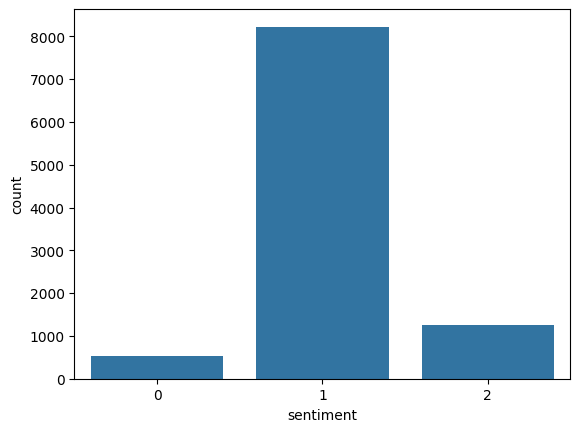

In [ ]:
# Summarise class details
sns.countplot(x=df['sentiment'])

In [ ]:
# use raw text
X_train_text, X_val_text, y_train, y_val = train_test_split(df['text'], df['sentiment'], test_size=0.3, random_state=RANDOM_SEED)
print(f'training data set size: {len(X_train_text)}')
print(f'validation data set size: {len(X_val_text)}')


training data set size: 6999
validation data set size: 3000


Since we need to evaluate all the models we are going to build using the same procedure, we can write a function for evaluation, which we can reuse for each model without repeatedly writing the same code.

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# method to calculate evaluation results
def evaluate(actuals, predictions, class_names):
  '''
  actuals: list of actual labels
  predictions: list of predicted labels
  class_names: list of classes used for the model/classification task
  '''
  # calculate accuracy
  accuracy = metrics.accuracy_score(actuals, predictions)
  print(f'Accuracy: {accuracy}')

    # plot confusion matrix
  confusion_matrix = metrics.confusion_matrix(actuals, predictions, labels=class_names)
  disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=class_names)
  disp.plot()
  plt.show()

  class_names = [str(c) for c in class_names]
  # Print the classification report
  print("Classification Report:\n", classification_report(actuals, predictions, target_names=class_names))



## SVM

Similar to our approach to evaluation, we can write a function to build an SVM model as follows.

In [ ]:
# method to train and predict using SVM classifier
def get_svm_predictions(X_train, X_val, y_train, y_val):
  # build model
  clf = svm.SVC(kernel='linear', random_state=RANDOM_SEED)
  clf.fit(X_train, y_train)

  # Make predictions on test data
  y_pred = clf.predict(X_val)

  # evalution
  evaluate(y_val, y_pred, clf.classes_)

  return clf

### Model M1

* Data preprocessing - lower casing, punctuation removal
* Features - term occurrence vector (1-grams)
* Algorithm - SVM

Accuracy: 0.7493333333333333


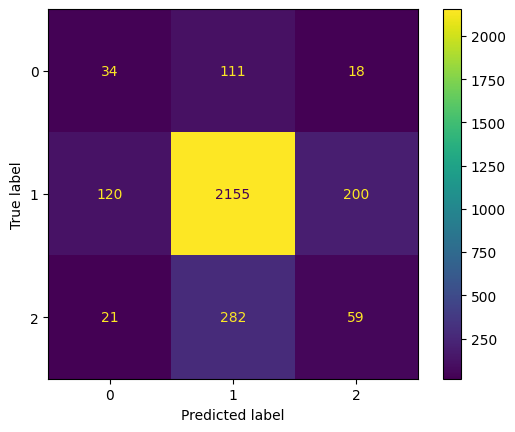

Classification Report:
               precision    recall  f1-score   support

           0       0.19      0.21      0.20       163
           1       0.85      0.87      0.86      2475
           2       0.21      0.16      0.18       362

    accuracy                           0.75      3000
   macro avg       0.42      0.41      0.41      3000
weighted avg       0.73      0.75      0.74      3000



In [ ]:
vectorizer = CountVectorizer()  # default: lowercase=True, ngram_range=(1,1)
vectorizer.fit(X_train_text)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_text)
X_val = vectorizer.transform(X_val_text)

m1 = get_svm_predictions(X_train, X_val, y_train, y_val)

### Model M2

* Data preprocessing - lower casing, punctuation removal
* Features - tf-idf vector (1-grams)
* Algorithm - SVM

Accuracy: 0.8266666666666667


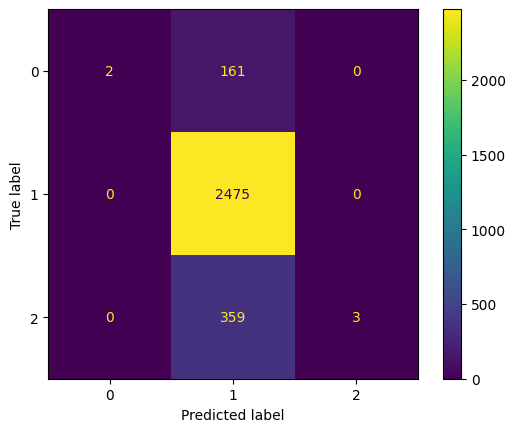

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.01      0.02       163
           1       0.83      1.00      0.90      2475
           2       1.00      0.01      0.02       362

    accuracy                           0.83      3000
   macro avg       0.94      0.34      0.32      3000
weighted avg       0.86      0.83      0.75      3000



In [ ]:
vectorizer = TfidfVectorizer()  # default: lowercase=True, ngram_range=(1,1)
vectorizer.fit(X_train_text)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_text)
X_val = vectorizer.transform(X_val_text)

m2 = get_svm_predictions(X_train, X_val, y_train, y_val)

According to the measures accuracy values model M2 is more accurate than model M1.

### Decision Tree

In [ ]:
# method to train and predict using Decision Tree
def get_dt_predictions(X_train, X_val, y_train, y_val):
  # build model
  clf = tree.DecisionTreeClassifier(random_state=RANDOM_SEED)
  clf.fit(X_train, y_train)

  # Make predictions on test data
  y_pred = clf.predict(X_val)

  # evalution
  evaluate(y_val, y_pred, clf.classes_)

  return clf

* Data preprocessing - lower casing, punctuation removal
* Features - tf-idf vector (1-grams)
* Algorithm - DecisionTreeClassifier

Accuracy: 0.7316666666666667


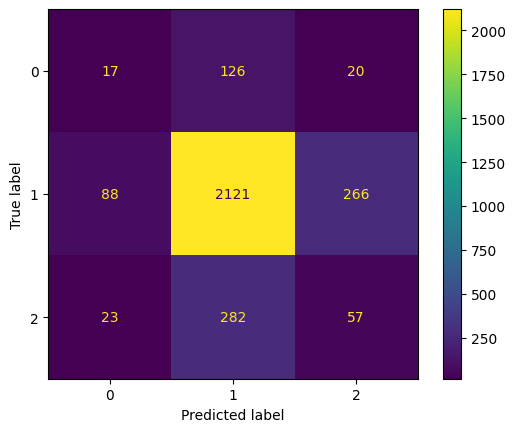

Classification Report:
               precision    recall  f1-score   support

           0       0.13      0.10      0.12       163
           1       0.84      0.86      0.85      2475
           2       0.17      0.16      0.16       362

    accuracy                           0.73      3000
   macro avg       0.38      0.37      0.38      3000
weighted avg       0.72      0.73      0.73      3000



In [ ]:
vectorizer = TfidfVectorizer()  # default: lowercase=True, ngram_range=(1,1)
vectorizer.fit(X_train_text)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_text)
X_val = vectorizer.transform(X_val_text)

m3 = get_dt_predictions(X_train, X_val, y_train, y_val)

In [ ]:
# libraries for ML algorithms
from sklearn.ensemble import RandomForestClassifier

# method to train and predict using SVM classifier
def get_randomforest_predictions(X_train, X_val, y_train, y_val):
  # build model
  classification = RandomForestClassifier(n_estimators=100, random_state=42)
  classification.fit(X_train, y_train)

  # Make predictions on validation data
  y_predict = classification.predict(X_val)

  # evalution model results
  evaluate(y_val, y_predict, classification.classes_)

  return classification

Accuracy: 0.8263333333333334


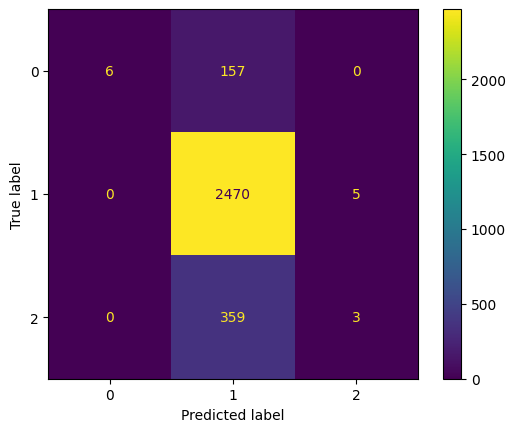

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.04      0.07       163
           1       0.83      1.00      0.90      2475
           2       0.38      0.01      0.02       362

    accuracy                           0.83      3000
   macro avg       0.73      0.35      0.33      3000
weighted avg       0.78      0.83      0.75      3000



In [ ]:

#covert train data to numeric vectors using count vectorizer
vectorizer = TfidfVectorizer()  # default: lowercase=True, ngram_range=(1,1)
# Fit the vectorizer on the original text data (X_train_text)
vectorizer.fit(X_train_text)

# convert train and test text data to numeric vectors, use different variable names
X_train_transformed = vectorizer.transform(X_train_text)
X_val_transformed = vectorizer.transform(X_val_text)

m4 = get_randomforest_predictions(X_train_transformed, X_val_transformed, y_train, y_val)


Accuracy: 0.8253333333333334


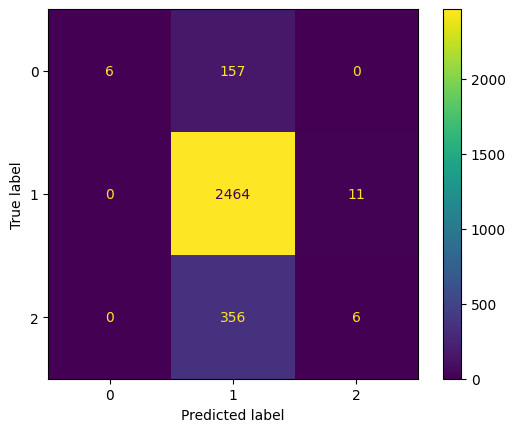

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.04      0.07       163
           1       0.83      1.00      0.90      2475
           2       0.35      0.02      0.03       362

    accuracy                           0.83      3000
   macro avg       0.73      0.35      0.34      3000
weighted avg       0.78      0.83      0.75      3000



In [ ]:
#covert train data to numeric vectors using count vectorizer
vectorizer = TfidfVectorizer( max_df=0.8,
    min_df=0.01,
    ngram_range=(1,1),
    max_features=5000,
    )  #Fine Tuning with params
# Fit the vectorizer on the  data
vectorizer.fit(X_train_text)

# convert train and test text data to numeric vectors, use different variable names
X_train_transformed = vectorizer.transform(X_train_text)
X_val_transformed = vectorizer.transform(X_val_text)

m4 = get_randomforest_predictions(X_train_transformed, X_val_transformed, y_train, y_val)


In [ ]:
from imblearn.over_sampling import RandomOverSampler
import numpy as np

ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(df['text']).reshape(-1, 1), np.array(df['sentiment']).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text', 'sentiment']);
train_os['sentiment'].value_counts()

sentiment
1    8223
0    8223
2    8223
Name: count, dtype: int64

In [ ]:
X = train_os['text'].values
y = train_os['sentiment'].values

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.62      0.60      1615
           1       0.50      0.55      0.52      1686
           2       0.52      0.43      0.47      1633

    accuracy                           0.53      4934
   macro avg       0.53      0.53      0.53      4934
weighted avg       0.53      0.53      0.53      4934

Accuracy: 0.53


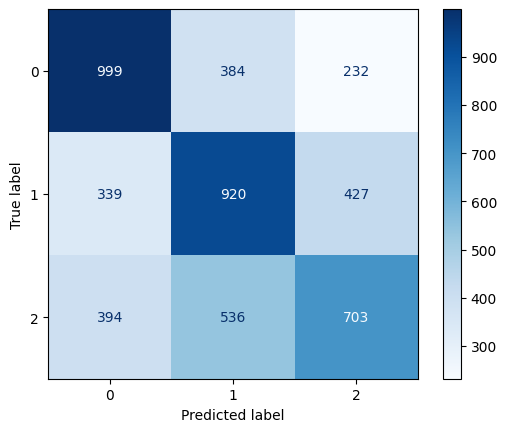

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and apply the TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_df=0.95, min_df=0.01, ngram_range=(1,2), stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Initialize and train the Naive Bayes classifier
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)

# Predict the labels on the test set
y_pred = nb.predict(X_test_tfidf)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()
